## Passing network

|Kazakhstan|Denmark|N_Ireland|
|---|---|---|
|<img src="https://github.com/ngroggy/SoccerAnalytics/blob/main/notebooks/plots/3-network/passing_network_Kazakhstan.jpeg?raw=true" align="center" height="350" width="600"/>|<img src="https://github.com/ngroggy/SoccerAnalytics/blob/main/notebooks/plots/3-network/passing_network_Denmark.jpeg?raw=true" align="center" height="350" width="600"/>|<img src="https://github.com/ngroggy/SoccerAnalytics/blob/main/notebooks/plots/3-network/passing_network_N_Ireland.jpeg?raw=true" align="center" height="350" width="600"/>|
|Finland|San_Marino|Denmark_2|
|---|---|---|
|<img src="https://github.com/ngroggy/SoccerAnalytics/blob/main/notebooks/plots/3-network/passing_network_Finland.jpeg?raw=true" align="center" height="350" width="600"/>|<img src="https://github.com/ngroggy/SoccerAnalytics/blob/main/notebooks/plots/3-network/passing_network_San_Marino.jpeg?raw=true" align="center" height="350" width="600"/>|<img src="https://github.com/ngroggy/SoccerAnalyt

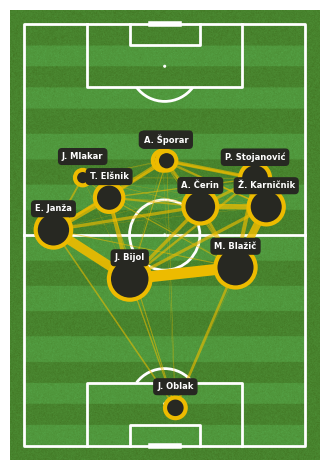

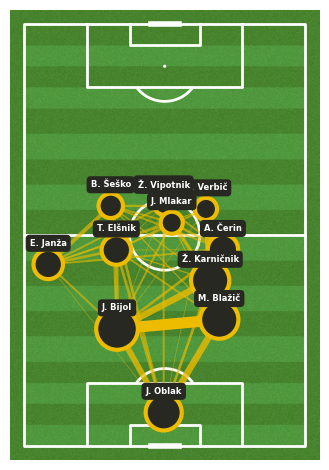

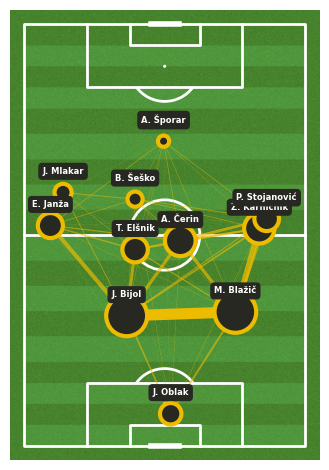

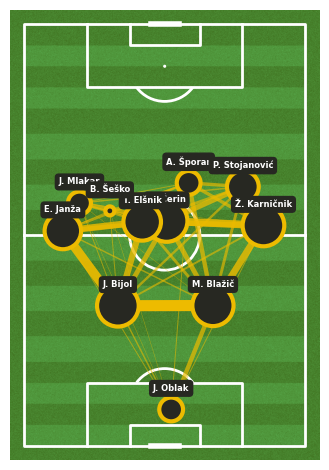

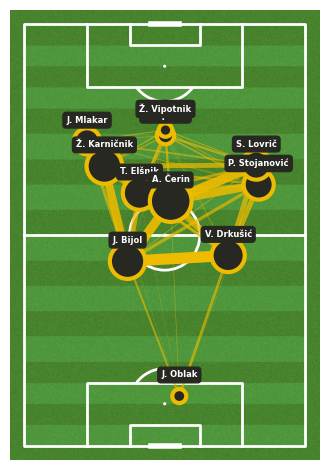

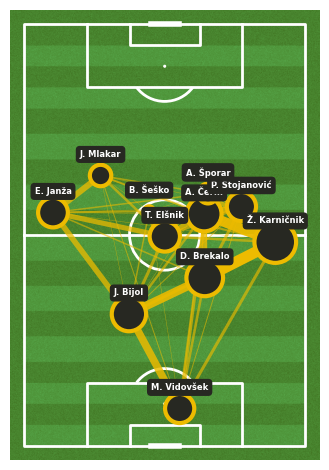

In [17]:
import pandas as pd
import numpy as np
from mplsoccer import VerticalPitch

import warnings
warnings.filterwarnings("ignore")

pitch_length = 120
pitch_width = 80


def plot_network(name_other_team, path, links):

    data = pd.read_csv(f"./results/wyscout/{path}_df_events.csv")

    data = data[['location.x', 'location.y', 'pass.endLocation.x', 'pass.endLocation.y', "player.name", "pass.recipient.name","team.name","minute",'player.id']]

    df_merged = data.rename(columns={
    'location.x':'x',
    'location.y':'y',
    'pass.endLocation.x':'end_x',
    'pass.endLocation.y':'end_y',
    "player.name":"player_name",
    "pass.recipient.name":"pass_recipient_name",
    "team.name":"team_name",
    "minute":"minute",
    "player.id":'player_id'
    })


    df_home_pass = df_merged[df_merged.team_name == 'Slovenia']

    # Check player play time
    home_player_df = df_merged[df_merged.team_name == 'Slovenia'].groupby('player_name').agg({'minute': [min, max]}).reset_index()
    home_player_df = pd.concat([home_player_df['player_name'], home_player_df['minute']], axis=1)
    home_player_df['minutes_played'] = home_player_df['max'] - home_player_df['min']
    home_player_df = home_player_df.sort_values('minutes_played', ascending=False)

    home_player_name = home_player_df.player_name[:11].tolist()
    df_home_pass = df_home_pass[df_home_pass.player_name.isin(home_player_name)]
    df_home_pass = df_home_pass[df_home_pass.pass_recipient_name.isin(home_player_name)]

    scatter_df = pd.DataFrame()
    for i, name in enumerate(df_home_pass["player_name"].unique()):
        passx = df_home_pass.loc[df_home_pass["player_name"] == name]["x"].to_numpy()
        recx = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
        passy = df_home_pass.loc[df_home_pass["player_name"] == name]["y"].to_numpy()
        recy = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
        scatter_df.at[i, "player_name"] = name

        #make sure that x and y location for each circle representing the player is the average of passes and receptions
        scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
        scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

        #calculate number of passes
        scatter_df.at[i, "no"] = df_home_pass.loc[df_home_pass["player_name"] == name].count().iloc[0]
        
    #adjust the size of a circle so that the player who made more passes
    scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 900)

    #Calculate edge width
    df_home_pass["pair_key"] = df_home_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
    lines_df = df_home_pass.groupby(["pair_key"]).x.count().reset_index()
    lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
    #setting a treshold
    lines_df = lines_df[lines_df['pass_count']> 0]


    import matplotlib.pyplot as plt
    pitch = VerticalPitch(pitch_color='grass', line_color='white', stripe=True)

    fig, ax = pitch.draw()

    pitch.scatter(scatter_df.x / 100 * pitch_length, scatter_df.y / 100 * pitch_width, s=scatter_df.marker_size, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax, zorder = 3)

    for i, row in scatter_df.iterrows():
        pitch.annotate(row.player_name, xy=(row.x/100 * pitch_length +6, row.y/100 * pitch_width), c='white', va='center',
                    ha='center', size=6, weight = "bold", ax=ax, zorder = 4, 
                    bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))
    

    for i, row in lines_df.iterrows():
            player1 = row["pair_key"].split("_")[0]
            player2 = row['pair_key'].split("_")[1]
            #take the average location of players to plot a line between them
            player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'] / 100 * pitch_length
            player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'] / 100 * pitch_width
            player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'] / 100 * pitch_length
            player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'] / 100 * pitch_width
            num_passes = row["pass_count"]
            #adjust the line width so that the more passes, the wider the line
            line_width = (num_passes / lines_df['pass_count'].max() * 8)
            # adjust the alpha of the lines based on number of passes and set minimum alpha for a fewer pass
            alpha = 0.5 * num_passes / lines_df['pass_count'].max() + 0.5
            #plot lines on the pitch
            pitch.lines(player1_x, player1_y, player2_x, player2_y,
                            alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax)

    plt.savefig(f'plots/3-network/passing_network_{name_other_team}.jpeg', dpi=200,bbox_inches='tight')


    links += f"<img src=\"https://github.com/ngroggy/SoccerAnalytics/blob/main/notebooks/plots/3-network/passing_network_{name_other_team}.jpeg?raw=true\" align=\"center\" height=\"350\" width=\"600\"/>|"
    #plt.show()

    return links


data = [("Kazakhstan", "5414324"),("Denmark", "5414302"),("N_Ireland", "5414284")]
data2 = [("Finland", "5414260"),("San_Marino", "5414226"),("Denmark_2","5414180")]

head = "|"
second = "|"
links = "|"
for against, match_id in data:
    head += f"{against}|"
    second += "---|"
    links = plot_network(against, match_id, links)

print(head)
print(second)
print(links)

head = "|"
second = "|"
links = "|"
for against, match_id in data2:
    head += f"{against}|"
    second += "---|"
    links = plot_network(against, match_id, links)

print(head)
print(second)
print(links)

In [18]:
import pandas as pd
import json
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch, Pitch



def preprocess_team_pass_data(df_events, team_name):
    df_passes = df_events[df_events['type.primary'] == 'pass']
    df_accurate_passes = df_passes[df_passes['pass.accurate'] == True]
    ap_team = df_accurate_passes[df_accurate_passes['team.name'] == team_name]
    filtered_passes = ap_team[['player.name', 'pass.recipient.name', 'location.x', 'location.y']].copy()
    average_positions = ap_team.groupby('player.name').agg({'location.x': 'mean', 'location.y': 'mean'}).reset_index()
    return filtered_passes, average_positions

def create_weighted_graph(df):
    G = nx.DiGraph()
    unique_players = set(df['player.name'])
    unique_recipients = set(df['pass.recipient.name'])

    for index, row in df.iterrows():
        player = row['player.name']
        recipient = row['pass.recipient.name']

        if player is None or recipient is None:
            continue

        if player not in unique_recipients or recipient not in unique_players:
            continue

        if G.has_edge(player, recipient):
            G[player][recipient]['weight'] += 1
        else:
            G.add_edge(player, recipient, weight=1)

    return G

def calculate_top_players(G):
    centrality_measures = {
        "Degree Centrality": nx.degree_centrality(G),
        "Betweenness Centrality": nx.betweenness_centrality(G),
        "Closeness Centrality": nx.closeness_centrality(G),
        "Eigenvector Centrality": nx.eigenvector_centrality(G),
        "PageRank Centrality": nx.pagerank(G) 
    }

    top_players = {}
    # Loop through each centrality measure
    for measure, centrality in centrality_measures.items():
        sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
        top_players[measure] = [f"{player}: {centrality_value:.4f}" for player, centrality_value in sorted_centrality[:3]]

    return top_players




data = [("Kazakhstan", "5414324"),("Denmark", "5414324"),("N_Ireland", "5414284"),("Finland", "5414260"),("San_Marino", "5414226"),("Denmark_2","5414180")]

centrality_measures = {
        "Degree Centrality": [],
        "Betweenness Centrality": [],
        "Closeness Centrality": [],
        "Eigenvector Centrality": [],
        "PageRank Centrality": [],
    }


for against, match_id in data:
    #example usage
    df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv")
    filtered_passes_g, average_positions_g = preprocess_team_pass_data(df_events, 'Slovenia')
    G = create_weighted_graph(filtered_passes_g)
    values = calculate_top_players(G)

    for val in values: 
        centrality_measures[val].append(f"|Against: {against} | " + str(values[val]) + "|")

for val in centrality_measures:
    print(f"|{val}|Top 3|")
    print("|---|---|")
    for line in centrality_measures[val]:
        print(line)


|Degree Centrality|Top 3|
|---|---|
|Against: Kazakhstan | ['T. Elšnik: 1.5000', 'P. Stojanović: 1.4286', 'J. Bijol: 1.3571']|
|Against: Denmark | ['T. Elšnik: 1.5000', 'P. Stojanović: 1.4286', 'J. Bijol: 1.3571']|
|Against: N_Ireland | ['A. Čerin: 1.6923', 'J. Bijol: 1.6923', 'B. Šeško: 1.6154']|
|Against: Finland | ['E. Janža: 1.4286', 'A. Čerin: 1.4286', 'T. Elšnik: 1.4286']|
|Against: San_Marino | ['A. Čerin: 1.8000', 'S. Lovrič: 1.6667', 'Ž. Karničnik: 1.6000']|
|Against: Denmark_2 | ['P. Stojanović: 1.8000', 'Ž. Karničnik: 1.7000', 'J. Bijol: 1.6000']|
|Betweenness Centrality|Top 3|
|---|---|
|Against: Kazakhstan | ['M. Blažič: 0.0779', 'nan: 0.0659', 'T. Elšnik: 0.0486']|
|Against: Denmark | ['M. Blažič: 0.0779', 'nan: 0.0659', 'T. Elšnik: 0.0486']|
|Against: N_Ireland | ['B. Šeško: 0.0911', 'A. Čerin: 0.0911', 'J. Bijol: 0.0824']|
|Against: Finland | ['E. Janža: 0.1679', 'A. Čerin: 0.1290', 'T. Elšnik: 0.0883']|
|Against: San_Marino | ['A. Čerin: 0.0857', 'J. Bijol: 0.0853', 'S